# Morphology
Summary:
- close = dilation + erosion
- when cross SE used for dilation followed by erosion, subdue fillings can be found on the closed coners (close)
- when box SE used for dilation followed by erosion, the original image is restored (not for O-shape).
- when non-symmetric SE used, the shape gets altered!

In [386]:
from importlib import reload
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipcv import cvlib
import utility.notebook_helper as nb

reload(nb)
reload(cvlib)

<module 'ipcv.cvlib' from '/Users/everhett/Projects/python-ws/qr-scanner/ipcv/cvlib.py'>

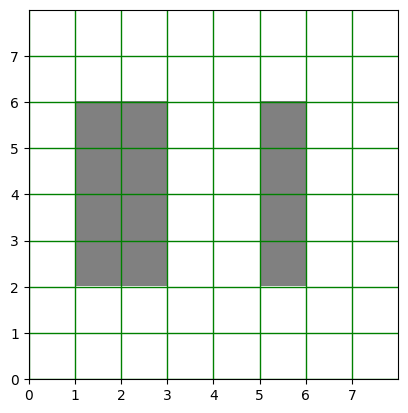

In [387]:
# O-shape: Closing is obvious in this.
mat1 = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]
])

# Cross
# se = np.array([
#     [0, 1, 0],
#     [1, 1, 1],
#     [0, 1, 0],
# ])

# Rect
# se = np.array([
#     [1, 1, 1],
#     [1, 1, 1],
#     [1, 1, 1],
# ])
se = np.array([
    [1, 1, 1]
])

# Need to convert them first for cv operations.
mat1 = mat1.astype('uint8')
se = se.astype('uint8')

# print(mat1)
nb.display_color_grids(mat1)

## Dilation and Erosion with Cross SE
Performing dilation and followed by erosion doesn't restore the source image. It <u>leaves fillings in closed corners</u>.
<p><b>This is true for close operation that dilates then erodes leaving fillings for closing.</b>

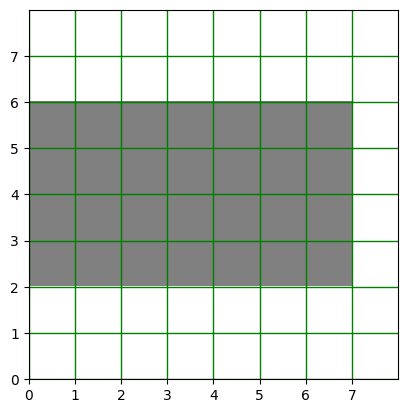

In [388]:
dilated = cv2.dilate(mat1, se, iterations=1)
# print(dilated)
# type(kernel)
nb.display_color_grids(dilated)

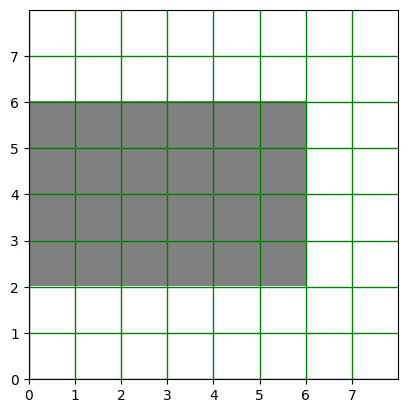

In [389]:
eroded = cv2.erode(dilated, se, iterations=1)
# print(eroded)
nb.display_color_grids(eroded)

In [390]:
# Leaves filling(s) on the closed corners.
np.array_equal(mat1, eroded)

False

## Erosion on Dilated with Cross SE
<b>Important:</b> Performing dilation to eroded image restores the original dilation!

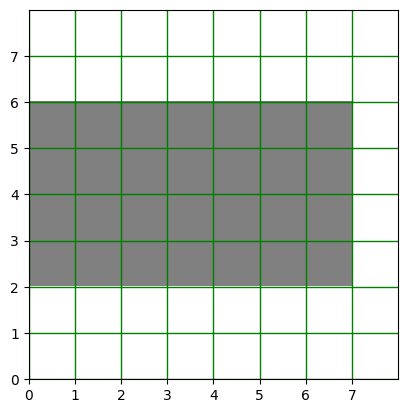

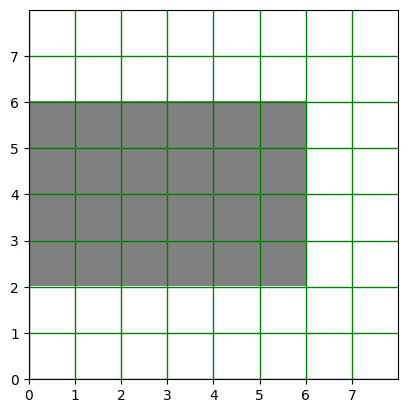

In [391]:
# print(dilated)
nb.display_color_grids(dilated)
nb.display_color_grids(eroded)

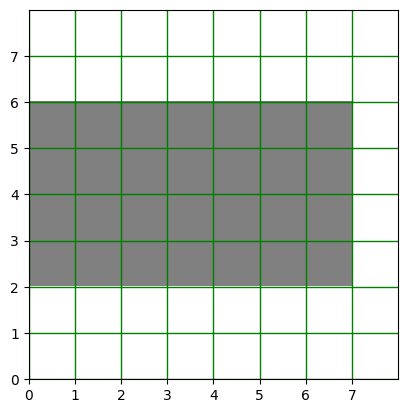

In [392]:
dilated2 = cv2.dilate(eroded, se, iterations=1)
nb.display_color_grids(dilated2)
# print(dilated2)

In [393]:
# Dilated and eroded is the same.
np.array_equal(dilated, dilated2)

True

## Experiment the theory with a gray image

In [394]:
image = cvlib.load_image('../resources/barcode/barcode121.jpg')
image = cvlib.convert_rgb2gray(image)
image.shape

(782, 1285)

In [395]:
binary = cvlib.binarize_inv(image,50)
# binary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
unique = np.unique(binary)
print(unique)

[  0 255]


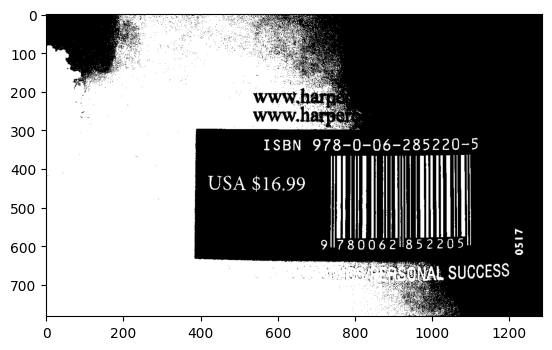

In [396]:
plt.imshow(binary, cmap='gray')

## Erosion on dilated with cross SE (on image)

In [397]:
# Dilate first.
# redefine se
# se = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
# Cross
# se = np.array([
#     [0, 1, 0],
#     [1, 1, 1],
#     [0, 1, 0],
# ])

# Rect
# se = np.array([
#     [1, 1, 1],
#     [1, 1, 1],
#     [1, 1, 1],
# ])
se = np.array([
    [1, 1, 1, 1, 1]
])

# se = np.array([
#     [1, 1, 1, 1, 1],
#     [0, 0, 0, 1, 1],
#     [0, 0, 0, 1, 1],
#     [0, 0, 0, 1, 1],
#     [0, 0, 0, 1, 1],
# ])

# se = np.array([
#     [1, 1, 1, 1, 1],
#     [0, 0, 0, 1, 1],
#     [0, 0, 0, 1, 1],
# ])

se = se.astype('uint8')
print(se)

[[1 1 1 1 1]]


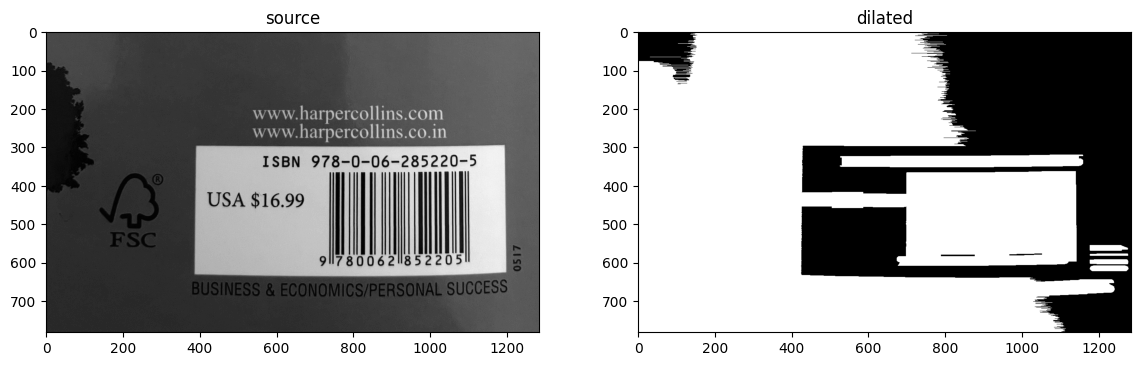

In [398]:
dilated_image = cv2.dilate(binary, se, iterations=20)
# plt.imshow(dilated_image, cmap='gray')
nb.display_for_comparisons(image, dilated_image, 'source', 'dilated')

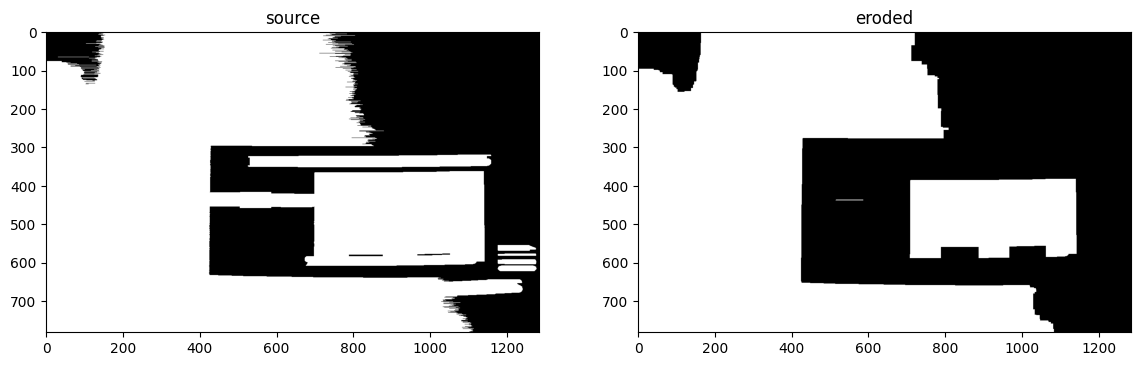

In [399]:
# Rect
se2 = np.array([
    [1, 1],
    [1, 1],
    [1, 1],
    [1, 1],
    [1, 1]
])
eroded_image = cv2.erode(dilated_image, se2, iterations=10)
# plt.imshow(dilated_image, cmap='gray')
nb.display_for_comparisons(dilated_image, eroded_image, 'source', 'eroded')

Image Area: 1004870
Required ratio: 22330.444444444445
Number of contours found: 3

Calculated area: 81128.5
Calculate ratio: 2.1067961165048543
Max-Area: 81128.5



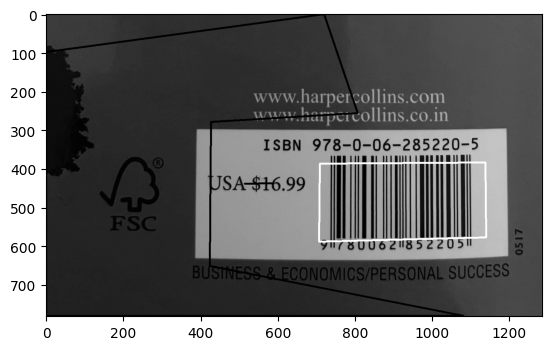

In [400]:
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)

contours, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_area = image.shape[0] * image.shape[1]
required_aspect_ration = image_area / 45

print(f'Image Area: {image_area}')
print(f'Required ratio: {required_aspect_ration}')
cropped = None
print(f'Number of contours found: {len(contours)}\n')

max_contour = None
max_area = 0
for contour in contours:
    # print(f'\nContour len: {len(contour)}')
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    # print(f'Approx len: {len(approx)}')
    cv2.drawContours(image, [approx], -1, GREEN, 3)
    if len(approx) == 4:
        area = cv2.contourArea(contour)
        print(f'Calculated area: {area}')

        (x, y, w, h) = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)
        print(f'Calculate ratio: {aspect_ratio}')

        # Ensure the QR-Code is a box shaped (max ratio of w:h = 1.2:1)
        # AND min area => 12 x 10
        # if area > 100 and 0.8 <= aspect_ratio <= 1.2:
        # if area > required_aspect_ration and 0.8 <= aspect_ratio <= 1.2:
        if area > required_aspect_ration :
            # if 0.8 <= aspect_ratio <= 1.2:
            if area > max_area:
                max_area = area
                print(f'Max-Area: {max_area}')
                max_contour = contour
        print('\r')

if max_contour is not None:
    perimeter = cv2.arcLength(max_contour, True)
    approx = cv2.approxPolyDP(max_contour, 0.04 * perimeter, True)
    cv2.drawContours(image, [approx], -1, RED, 3)
    (x, y, w, h) = cv2.boundingRect(approx)
    cropped = image[y:y + h, x:x + w]

plt.imshow(image, cmap='gray')

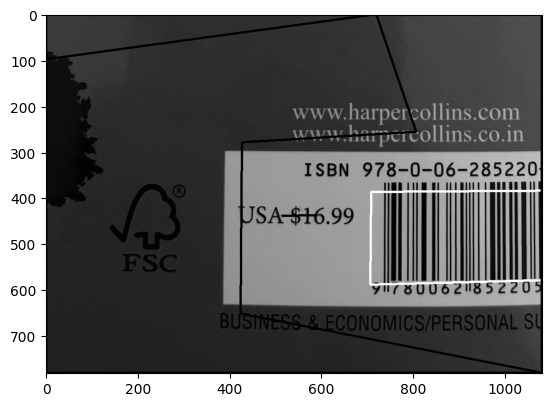

In [401]:
cropped = cvlib.get_prominent_contour(image, eroded_image, 0)
plt.imshow(cropped, cmap='gray')